<a href="https://colab.research.google.com/github/21-501/marthala-Padmaja-/blob/main/final_handwriting_recognition_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [50]:
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [51]:

# ✅ Load dataset (Example: MNIST) - Modify if using a different dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

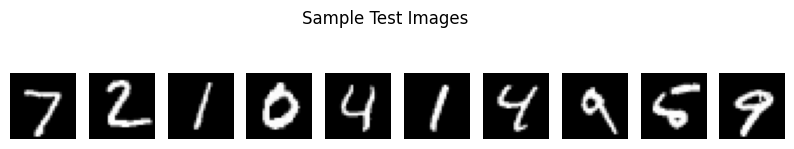

In [52]:
import matplotlib.pyplot as plt

# ✅ Display some sample test images
num_samples = 10
plt.figure(figsize=(10, 2))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Test Images")
plt.show()


In [53]:
# ✅ Print dataset shapes
print(f"Training Data Shape: {x_train.shape}, Labels Shape: {y_train.shape}")
print(f"Test Data Shape: {x_test.shape}, Labels Shape: {y_test.shape}")


Training Data Shape: (60000, 28, 28), Labels Shape: (60000,)
Test Data Shape: (10000, 28, 28), Labels Shape: (10000,)


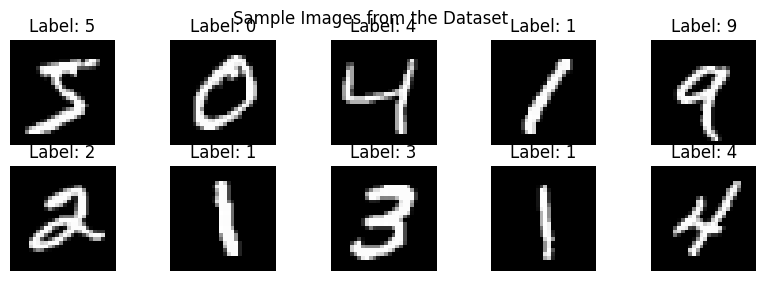

In [54]:
# ✅ Display 10 random training images
plt.figure(figsize=(10, 3))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {y_train[i]}")

plt.suptitle("Sample Images from the Dataset")
plt.show()


<ipython-input-55-2082d5ba8bda>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="viridis")


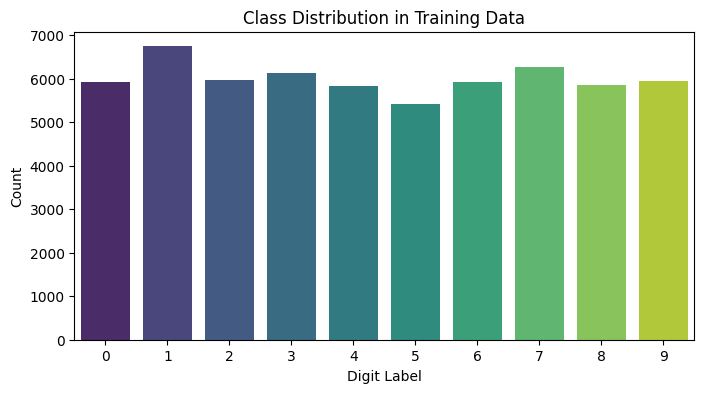

In [55]:
# ✅ Plot class distribution of training dataset
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="viridis")
plt.title("Class Distribution in Training Data")
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.show()


In [56]:
# ✅ Check pixel intensity statistics
print(f"Mean pixel value: {np.mean(x_train)}")
print(f"Standard deviation of pixel values: {np.std(x_train)}")


Mean pixel value: 33.318421449829934
Standard deviation of pixel values: 78.56748998339798


In [57]:
# ✅ Check for missing values in dataset
print("Missing Values in x_train:", np.isnan(x_train).sum())
print("Missing Values in y_train:", np.isnan(y_train).sum())
print("Missing Values in x_test:", np.isnan(x_test).sum())
print("Missing Values in y_test:", np.isnan(y_test).sum())


Missing Values in x_train: 0
Missing Values in y_train: 0
Missing Values in x_test: 0
Missing Values in y_test: 0


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


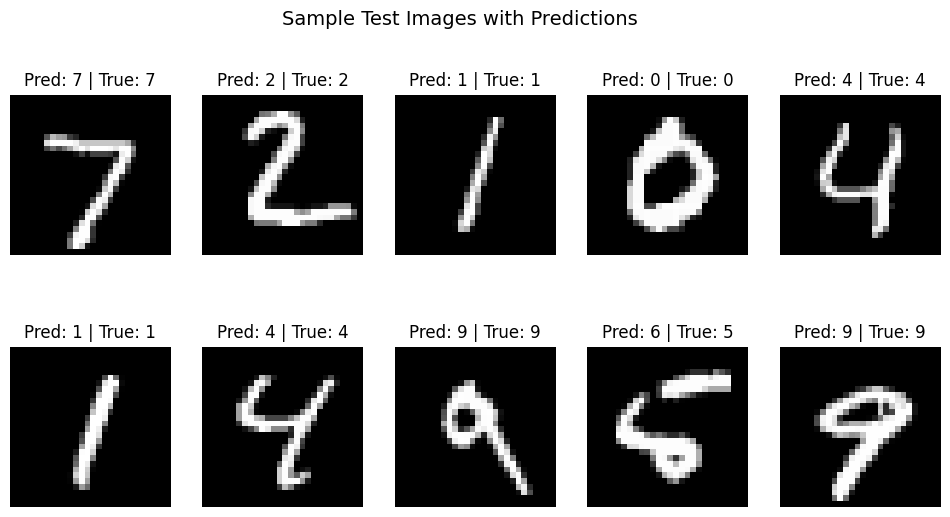

In [58]:
# ✅ Function to display test images with predictions
def display_predictions(model, x_test, y_test, num_images=10):
    plt.figure(figsize=(12, 6))

    predictions = model.predict(x_test)
    predicted_labels = np.argmax(predictions, axis=1)

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        plt.title(f"Pred: {predicted_labels[i]} | True: {y_test[i]}")

    plt.suptitle("Sample Test Images with Predictions", fontsize=14)
    plt.show()

# ✅ Call the function
display_predictions(model, x_test, y_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


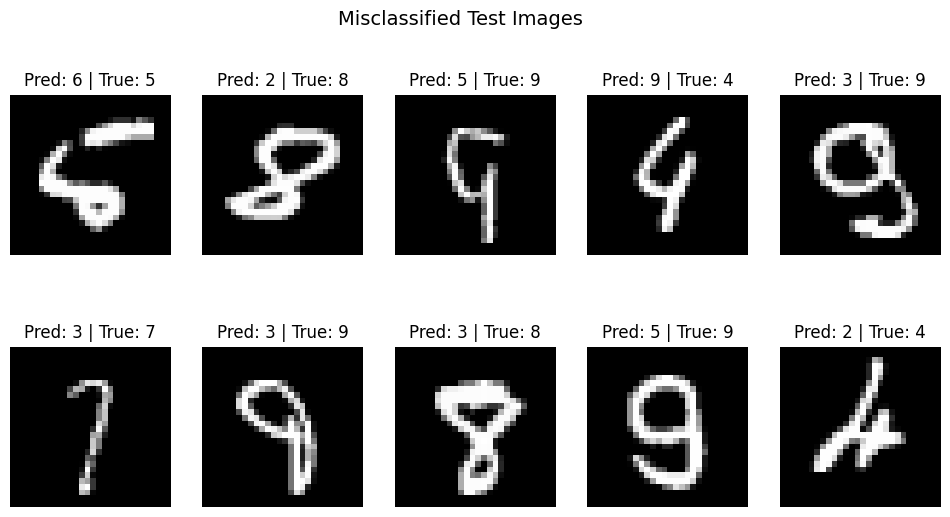

In [59]:
# ✅ Function to display misclassified images
def display_misclassified(model, x_test, y_test, num_images=10):
    plt.figure(figsize=(12, 6))

    predictions = model.predict(x_test)
    predicted_labels = np.argmax(predictions, axis=1)

    misclassified_indices = np.where(predicted_labels != y_test)[0]

    for i, index in enumerate(misclassified_indices[:num_images]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[index].reshape(28, 28), cmap="gray")
        plt.axis("off")
        plt.title(f"Pred: {predicted_labels[index]} | True: {y_test[index]}")

    plt.suptitle("Misclassified Test Images", fontsize=14)
    plt.show()

# ✅ Call the function
display_misclassified(model, x_test, y_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


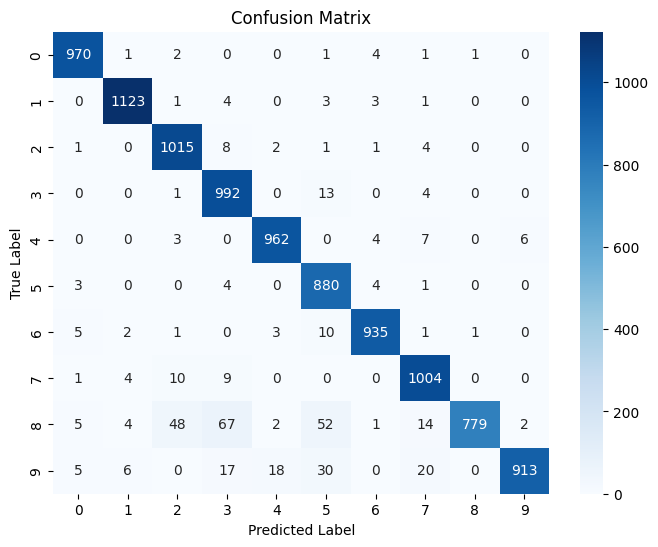

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ✅ Generate and plot confusion matrix
def plot_confusion_matrix(model, x_test, y_test):
    predictions = model.predict(x_test)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(y_test, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ✅ Call the function
plot_confusion_matrix(model, x_test, y_test)


In [62]:
# ✅ Normalize the data (Scaling pixels to [0,1])
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [63]:

# ✅ Ensure labels are integer-encoded (Change if using categorical loss)
if len(y_train.shape) > 1:  # If one-hot encoded, convert back
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

In [64]:
# ✅ Model Architecture (Regularization + Dropout for Stability)
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Converts 2D image to 1D vector
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),  # Helps stabilize training
    Dropout(0.3),  # Prevents overfitting

    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation='softmax')  # 10 classes for MNIST
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
# ✅ Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
# ✅ Train the model with Validation
history = model.fit(x_train, y_train, epochs=20, batch_size=64,
                    validation_data=(x_test, y_test), verbose=2)

Epoch 1/20
938/938 - 12s - 12ms/step - accuracy: 0.8773 - loss: 0.4304 - val_accuracy: 0.9549 - val_loss: 0.1722
Epoch 2/20
938/938 - 5s - 5ms/step - accuracy: 0.9370 - loss: 0.2443 - val_accuracy: 0.9630 - val_loss: 0.1481
Epoch 3/20
938/938 - 3s - 3ms/step - accuracy: 0.9460 - loss: 0.2082 - val_accuracy: 0.9683 - val_loss: 0.1351
Epoch 4/20
938/938 - 2s - 3ms/step - accuracy: 0.9544 - loss: 0.1832 - val_accuracy: 0.9708 - val_loss: 0.1243
Epoch 5/20
938/938 - 3s - 4ms/step - accuracy: 0.9569 - loss: 0.1758 - val_accuracy: 0.9722 - val_loss: 0.1195
Epoch 6/20
938/938 - 5s - 5ms/step - accuracy: 0.9604 - loss: 0.1644 - val_accuracy: 0.9743 - val_loss: 0.1198
Epoch 7/20
938/938 - 3s - 3ms/step - accuracy: 0.9639 - loss: 0.1543 - val_accuracy: 0.9763 - val_loss: 0.1117
Epoch 8/20
938/938 - 3s - 3ms/step - accuracy: 0.9647 - loss: 0.1520 - val_accuracy: 0.9751 - val_loss: 0.1198
Epoch 9/20
938/938 - 3s - 3ms/step - accuracy: 0.9658 - loss: 0.1485 - val_accuracy: 0.9760 - val_loss: 0.1155

In [67]:
# ✅ Evaluate on Test Data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\n🔥 Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"🔥 Final Test Accuracy: {test_acc:.4f}")


🔥 Final Training Accuracy: 0.9719
🔥 Final Test Accuracy: 0.9795


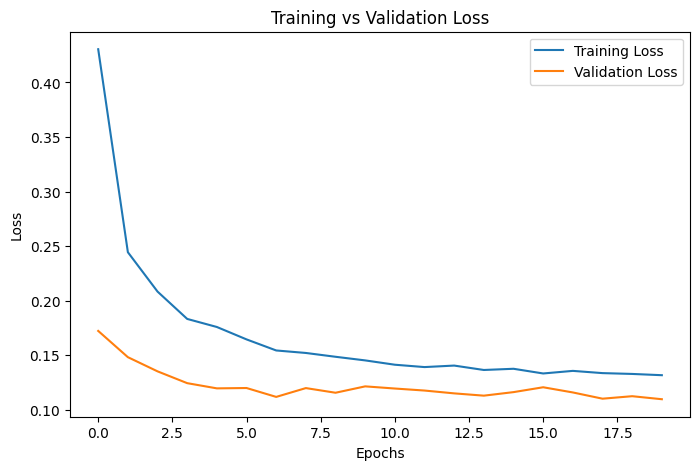

In [68]:

# ✅ Plot Training vs. Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
